#Resubmission Changes

Links go to updated changes in the document:

1. <a href='#resubmit1'>Reinterpreted and properly cited KNN introduction section.</a>
2. <a href='#resubmit2'>Change evaluation metric for classification tasks to F-score, rewrote the evaluation metric section.</a>
3. <a href='#resubmit3'>Added short description of previous work completed, the logistic regression.</a>
4. <a href='#resubmit4'>Evaluated KNN classification models with the F-score option in cross_val_score, iterated through values of K</a>
5. <a href='#resubmit5'>Evaluated Random Forest classification models with the F-score option in cross_val_score.</a>
6. <a href='#resubmit6'>Added boxplot of residuals for each regression</a>
7. <a href='#resubmit7'>Evaluated regression models with the R2 and Mean Squared Error option in cross_val_score.</a>
8. <a href='#resubmit8'>Introduced previous work in introduction below.</a>
9. <a href='#resubmit9'>Added more explaination regarding feature importantances on the GBRT.</a>
10. <a href='#resubmit10'>Updated conclusion table for new evaluation metric for task 1</a>

#Classification Lab 
##Carrie Garcia, Trenton Manson and Brian Mente
##11/8/2015
##*Contains Changes For Resubmission*
<a id='resubmit8'></a>

In this lab, we continue to work with the Dallas Police Department Incident Report Dataset. We will also use the same variables we used in the previous lab (see it referred to later as reduced model 2). We will carry out the two tasks below by creating several models for each and comparing how well each one meets our evaluation criteria.

* Classify incidents by the whether or not an arrest is made
* Regress the response time for each incident 

Our goal in carrying out these two tasks is to learn more about what is associated with the arrest rate of incidents in the database, and the response time between when incident calls are received and officiers are dispatched.  Insights into these relationships can help the Dallas Police Department staff appropriately and strategize for future process improvements. You can find the dataset - which is refreshed frequently - here:

https://www.dallasopendata.com/Police/Dallas-Police-Public-Data-RMS-Incidents/tbnj-w5hb  

## Setup

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn import metrics as mt
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
plt.style.use('ggplot')
import seaborn as sns

CarriePath ='Downloads/Dallas_Police_Public_Data_-_RMS_Incidents.csv'
MentePath = 'C:\\Users\Laura_2\Documents\SMU\MSDS7331\DPDData.csv'
MansonPath = '/Users/trent/Downloads/crime.csv'

df = pd.read_csv(MentePath) #read in the csv file

df = df.drop(['IncidentNum','ServNum','ServiceNum','ServiceNum','ServNumID', #drop unncessary columns
              'ObjAttack','RA','DPDSwornMarshalls','CompName','CompHAddress',
              'CompHApt','CompHZipCode','CompCity','CompState','CompBusName',
              'CompBAddress','SerNumLetter','Weather','RO1Badge','RO1Name',
              'RO2Badge','RO2Name','ReptOff','AssOffBadge','EleNum','FollowUp',
              'FollowUp2','SplRpt','UCRDisp','UCR1','UCR2','LatestUCR','CJIS',
              'PenalCode','OffenseCodeCC','VicPckg','UpzDate','MapDate',
              'ReviewBadgeNum','ServYr','Signal','OffIncident','PCClass','Premise','Blk',
              'Dir','StrName','Address','AptNum','ZipCode','Time1','City','State','Beat','Division','Sector',
              'District','TAAG','Community','Year1','Month1','Date1','Date1DayOfYear','Date2',                   
              'Year2','Month2','Day2','Time2','Date2DayOfYear','StartDateTime','StopDateTime',          
              'ReportedDate','EDate','EYear','EMonth','EDay','ETime','EDateDayOfYear','Involvement',
               'CompSex','CompAge','CompAgeAtOffenseTime','VictimInjuryDesc','VictimCond',
              'OffenseCode','UCROffense','Type','Family','MO'], 1)

df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117562 entries, 0 to 117561
Data columns (total 14 columns):
Watch             117562 non-null object
PointX            112163 non-null float64
PointY            112163 non-null float64
Day1              117561 non-null object
CallOrgDate       117121 non-null object
CallReceived      117121 non-null object
CallCleared       116980 non-null object
CallDispatched    117109 non-null object
CompRace          74680 non-null object
Status            117227 non-null object
UCROffDesc        117562 non-null object
Hate              117 non-null object
Gang              117538 non-null object
Drug              117538 non-null object
dtypes: float64(2), object(12)
memory usage: 13.5+ MB


C:\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## Organization

In [3]:
# Changing Call Times from strings to datetime objects
df.CallOrgDate = pd.to_datetime(df.CallOrgDate, format="%m/%d/%Y %I:%M:%S %p")
df.CallReceived = pd.to_datetime(df.CallReceived,format="%m/%d/%Y %I:%M:%S %p")
df.CallCleared = pd.to_datetime(df.CallCleared, format="%m/%d/%Y %I:%M:%S %p")
df.CallDispatched = pd.to_datetime(df.CallDispatched, format="%m/%d/%Y %I:%M:%S %p")

# Coding Binary ArrestMade variable  
def func2(row):
    if row['Status'] == 'Clear by Arrest':
        return 1
    elif row['Status'] == 'Clear by Exceptional Arrest':
        return 1 
    else:
        return 0

df['ArrestMade'] = df.apply(func2, axis=1)

# Categorizing Types of Crime
def func(row):
    if row['UCROffDesc'] == 'THEFT':
        return 'THEFT'
    elif row['UCROffDesc'] == 'BURGLARY':
        return 'BURGLARY' 
    elif row['UCROffDesc'] == 'CRIMINAL MISCHIEF/VANDALISM':
        return 'CRIMINAL MISCHIEF/VANDALISM' 
    elif row['UCROffDesc'] == 'AUTO THEFT - UUMV':
        return 'AUTO THEFT - UUMV'
    elif row['UCROffDesc'] == 'ROBBERY':
        return 'ROBBERY' 
    else:
        return 'OTHER'
    
df['FreqCrimes'] = df.apply(func, axis=1)
    
# Coding Binary Hate Crime variable  
def func3(row):
    if row['Hate'] == 'Yes':
        return 1
    else:
        return 0

df['Hate'] = df.apply(func3, axis=1)

# Coding Binary Gang Crime variable  
def func4(row):
    if row['Gang'] == 'Yes':
        return 1
    else:
        return 0

df['Gang'] = df.apply(func4, axis=1)

# Coding Binary Drug Crime variable  
def func5(row):
    if row['Drug'] == 'Yes':
        return 1
    else:
        return 0

df['Drug'] = df.apply(func5, axis=1)

# Coding out the U's from Watch variable  
def func6(row):
    if row['Watch'] == 'U':
        return 0
    else:
        return int(row['Watch'])
df['Watch'] = df.apply(func6, axis=1)

# Calculating Response Time from call received to units dispatched.
df['ResponseTime'] = pd.Series(data=(df.CallDispatched-df.CallReceived).astype('timedelta64[m]').astype('float'),index=df.index,name='Response Time')
df.ResponseTime.describe()

# Dropping records with ResponseTime>1400 and <0 records
df = df[df.ResponseTime != -51]
df = df[df.ResponseTime != 1463]
df = df[df.ResponseTime != 1438]
df = df[df.CompRace != 'TEST']

df_final = df[np.isfinite(df['PointX'])]
df_final = df_final[np.isfinite(df['ResponseTime'])]

# one hot encoding for FreqCrimes
tmp_df = pd.get_dummies(df_final.UCROffDesc,prefix='FC')
df_final = pd.concat((df_final,tmp_df),axis=1)

# one hot encoding for Day1
tmp_df = pd.get_dummies(df_final.Day1,prefix='DOW')
df_final = pd.concat((df_final,tmp_df),axis=1)

# one hot encoding for CompRace
tmp_df = pd.get_dummies(df_final.CompRace,prefix='Race')
df_final = pd.concat((df_final,tmp_df),axis=1)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [4]:
df_final = df_final.drop(['FreqCrimes','Day1','CompRace','CallOrgDate','CallReceived',
                         'CallDispatched','CallCleared','Status','UCROffDesc'], 1)
df_full = df_final.copy()
df_full.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111748 entries, 0 to 117561
Data columns (total 54 columns):
Watch                             111748 non-null int64
PointX                            111748 non-null float64
PointY                            111748 non-null float64
Hate                              111748 non-null int64
Gang                              111748 non-null int64
Drug                              111748 non-null int64
ArrestMade                        111748 non-null int64
ResponseTime                      111748 non-null float64
FC_ACCIDENTAL INJURY              111748 non-null float64
FC_AGGRAVATED ASSAULT             111748 non-null float64
FC_ANIMAL BITE                    111748 non-null float64
FC_ARSON                          111748 non-null float64
FC_ASSAULT                        111748 non-null float64
FC_AUTO THEFT - UUMV              111748 non-null float64
FC_BURGLARY                       111748 non-null float64
FC_CHILD (OFFENSES AGAINST)  

In [5]:
#check for null values
df_full.isnull()
df_full.isnull().any(axis=1)
df_full[df_full.isnull().any(axis=1)]

,Watch,PointX,PointY,Hate,Gang,Drug,ArrestMade,ResponseTime,FC_ACCIDENTAL INJURY,FC_AGGRAVATED ASSAULT,...,DOW_Tue,DOW_Wed,Race_A,Race_B,Race_C,Race_I,Race_L,Race_N,Race_U,Race_W


In [6]:
#Show the first five rows of the dataframe
df_full.head()

,Watch,PointX,PointY,Hate,Gang,Drug,ArrestMade,ResponseTime,FC_ACCIDENTAL INJURY,FC_AGGRAVATED ASSAULT,...,DOW_Tue,DOW_Wed,Race_A,Race_B,Race_C,Race_I,Race_L,Race_N,Race_U,Race_W
0,1,2518554.843609,6956312.372005,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2510170.137785,6964579.867455,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2468149.477886,6991039.919647,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,2483568.791661,6936538.753386,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2466750.347141,6952366.005344,0,0,0,0,55,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# just checking things are looking okay

X = df_full.values
y = df_full['ArrestMade']

print (X.shape)
print (y.shape)

(111748, 54)
(111748,)


There are 111,748 incidents (rows) and 54 attributes (columns) in the full dataframe.

In [8]:
#replicating Brian's reduced model No. 2 from previous assignment

df_reduced2 = df_final.copy()
df_reduced2 = df_final.drop(['DOW_Mon','DOW_Tue','DOW_Wed','DOW_Thu','DOW_Fri','DOW_Sat','DOW_Sun', 'Gang','Hate','Race_I'
                             ,'Race_U','Race_C','Race_N'],1) 
df_reduced2.shape

if 'ArrestMade' in df_reduced2:
    y2 = df_reduced2['ArrestMade'].values # get the labels we want
    del df_reduced2['ArrestMade'] # get rid of the class label
    X2 = df_reduced2.values # use everything else to predict!
    


# Task 1 - Arrest Made Classification

Our first task will compare multiple models ability to predict whether or not an arrest was made from an incident in the data set.  Incidents with arrests make up about 10% of the data, as shown in the plot below.

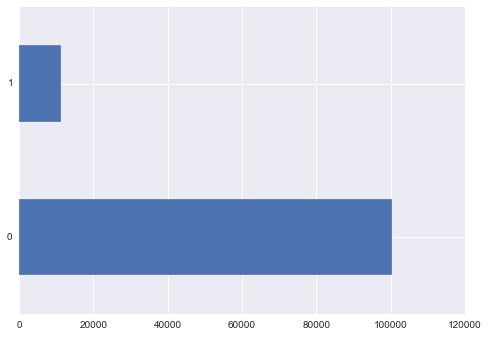

In [9]:
#showing frequency of ArrestMade class - - not using accuracy as an evaluation method
df_full.ArrestMade.value_counts().plot(kind='barh')

##Evaluation Metrics  
##*Contains Changes For Resubmission*
<a id='resubmit2'></a>

In consideration of an an evaluation metric for these models, our group decided the two most important aspects of each model are the recall and the precision of each.  Recall measures how well the classifier can find true positives as a proportion of the total actual positives in the data set, which is obviously important when attempting to predict if an incident will result in an arrest.  Just as important however, is the precision of the model, which measures the number of true positives as a proportion of the postives predicted by the model.  Models that are skewed too much in either recall or precision could have negative consequences in deployment, so we would like to pick a metric that is a balance of both.  For this reason, we'll use the F-score, which is calculation of the harmonic mean of both recall and precision.    

References texts: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html; Tan, Steinbach, and Kumar, "Introduction to Data Mining" pg 297


## Cross Validation Method

We chose a stratified 10-fold cross validation.  Our data set is very large so we we didn't feel the need to pick a large K to increase the accuracy of the resulting model, it should already be very accurate even with a K on the smaller side.  We also didn't want to pick a cross-validation method that would be too computationally intense (such as leave-one-out CV). 10-fold cross validation is a common choice, and we didn't feel any need to deviate from it. 10 folds should give a decent trade off between the bias and variance of the estimators.


## Model 1 - K Nearest Neighbors
<a id='resubmit1'></a>

##*Contains Changes For Resubmission*
The KNN algorithm can be used for either classification or regression.  When used for classification, a record is classified based on the majority vote of k-number of neighbor.  This means that the class is assigned based on the the most common class of the nearest neighbors.  The nearness of the neighbors is calculated on their distance in a two dimensional space.  The KNN algorithm is non parametric, meaning there are no underlyting assumptions about the structure of the data that are required for the analysis to be valid. 

With this particular classification task, we felt K-Nearest Neighbors would be an appropriate model to use. One advantage is that rule-based classifiers can be powerful for data sets that have imbalanced class distributions, such as ours.  This is true for the Decision Forest model used in model 2 as well. Another strength is the non-parametric nature of the model.  Given that this data set has a large number of categorical variables, we expect that this model wil perform better than our previous logistic regression model, a parametric model with many underlying assumptions.

Reference texts:  http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html; Tan, Steinbach, and Kumar, "Introduction to Data Mining" pg 223-227 

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
import numpy as np
from sklearn import metrics as mt

# create variables we are more familiar with
yhat2 = np.zeros(y2.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y2, n_folds=10)

# get a handle to the classifier object, which defines the type
clf_K3 = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_K3.fit(X2[train],y2[train])
    yhat2[test] = clf_K3.predict(X2[test])

#total_accuracy = mt.accuracy_score(y2, yhat2)
recall = mt.recall_score(y2[test], yhat2[test])
precision = mt.precision_score(y2[test], yhat2[test])
fscore = mt.f1_score(y2[test], yhat2[test])
#print('KNN accuracy is ', total_accuracy)
print('KNN recall is ', recall)
print('KNN precision is ', precision)

fscore = mt.f1_score(y2[test], yhat2[test])
print('Evaluation Metric: F-score is ', fscore)

KNN recall is  0.215289982425
KNN precision is  0.324933687003
Evaluation Metric: F-score is  0.258985200846


In [11]:
#changing n_neighbors to 11
clf_K11 = KNeighborsClassifier(n_neighbors=11)

for train, test in cv:
    clf_K11.fit(X2[train],y2[train])
    yhat2[test] = clf_K11.predict(X2[test])

#total_accuracy = mt.accuracy_score(y2, yhat2)
recall = mt.recall_score(y2[test], yhat2[test])
precision = mt.precision_score(y2[test], yhat2[test])
#print('KNN accuracy is ', total_accuracy)
print('KNN recall is ', recall)
print('KNN precision is ', precision)

fscore = mt.f1_score(y2[test], yhat2[test])
print('Evaluation Metric: F-score is ', fscore)

KNN recall is  0.165202108963
KNN precision is  0.559523809524
Evaluation Metric: F-score is  0.255088195387


In [13]:
from sklearn.cross_validation import cross_val_score
#lets loop through a range of possible numbers of neighbors and see what maximizes the f-score
f_scores=[]
for neighbors in [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33]: 

    clf_n = KNeighborsClassifier(n_neighbors=neighbors)

    for train, test in cv:
        clf_n.fit(X2[train],y2[train])
        yhat2[test] = clf_n.predict(X2[test])
        
    fscore = mt.f1_score(y2[test], yhat2[test])
    print('Evaluation Metric: For ',neighbors, ' neighbors F-score is ', fscore)
    if (neighbors == 5):
        f5 = cross_val_score(clf_n, X2, y=y2, scoring = 'f1', cv=cv)
    if (neighbors == 33):
        f33 = cross_val_score(clf_n, X2, y=y2,scoring = 'f1', cv=cv)
    f_scores.append(fscore)

Evaluation Metric: For  3  neighbors F-score is  0.258985200846
Evaluation Metric: For  5  neighbors F-score is  0.260355029586
Evaluation Metric: For  7  neighbors F-score is  0.257575757576
Evaluation Metric: For  9  neighbors F-score is  0.257725180802
Evaluation Metric: For  11  neighbors F-score is  0.255088195387
Evaluation Metric: For  13  neighbors F-score is  0.251221214236
Evaluation Metric: For  15  neighbors F-score is  0.251046025105
Evaluation Metric: For  17  neighbors F-score is  0.246652572234
Evaluation Metric: For  19  neighbors F-score is  0.242038216561
Evaluation Metric: For  21  neighbors F-score is  0.241867043847
Evaluation Metric: For  23  neighbors F-score is  0.243553008596
Evaluation Metric: For  25  neighbors F-score is  0.242467718795
Evaluation Metric: For  27  neighbors F-score is  0.236652236652
Evaluation Metric: For  29  neighbors F-score is  0.236141108711
Evaluation Metric: For  31  neighbors F-score is  0.226579520697
Evaluation Metric: For  33  n

<a id='resubmit4'></a>
Per sklearn documentation, "A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly."

As we increase the number of neighbors, recall decreases and precision increases.  But the overall impact on the F-score is a negative one. The 5-nearest neighbor model has the best F-score of 0.26, and thuse will be used to compare to our other calssification models. 

In [14]:
#taken from Github notebook from Dr. Larson
#compare the fscore of the 5-nearest neighbor model to the fscore of the 33-nearest neighbor model
from sklearn.cross_validation import cross_val_score

#Use t-score at the 95% Confidence Level
t = 2.26 / np.sqrt(10)

e = (1-f5)-(1-f33)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(f5), np.mean(f33))

Range of: -0.0543135229222 -0.0350032706318
0.241701935848 0.197043539071


The confidence interval does not include zero, so we can reject the null hypothesis that the two models have equal f-scores.  The results suggest that the model with 5 nearest neighbors (see mean f5 score in output) has a statistically significant different f-score than the model with 33 nearest neighbors, with the best estimate of that difference being roughly 0.0447.

## Model 2 - Random Forest

A random forest is an ensemble of decision trees which will output a prediction value, in this case, will an arrest take place. Each decision tree is constructed by using a random subset of the training data. After you have trained your forest, you can then pass each test row through it, in order to output a prediction. 
 
In Decision Tree and Random Forests, we have no probabilistic model, just binary splits, so we don't need to make any assumptions at all.  This is the advantage of using a non-parametric method.The difference is that for Random Forest we use Bootstrap Aggregation. There is no underlying statistical assumptions other than the sampling be representative.

Some advantages of these methods are that they are simple to understand and to interpret. They can be easily visualized. They also don't require alot of data preperation ie data doesn't need to be normalized. Decision trees also have relatively low cost computationally. They are flexible in that they are able to handle both numerical and categorical data. 

There are also disadvantages to decision trees. Decision-tree learners can also be overfit creating over-complex trees that do not generalise the data well. Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. These problems are mitigated by using decision trees within an ensemble.

As mentioned earlier, the large number of categorical variables in this dataset makes it a good fit for rule-based classifiers such as a random forest. 

(reference texts:  http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) 


In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=50, n_estimators=100, n_jobs=-1, oob_score=True, max_features=5)
from sklearn.preprocessing import StandardScaler
# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    scl_obj = StandardScaler()
    scl_obj.fit(X2[train]) 
    X_train_scaled = scl_obj.transform(X2[train]) # apply to training
    X_test_scaled = scl_obj.transform(X2[test]) # apply those means and std to the test set (without snooping at the test set values)
    clf_RF.fit(X_train_scaled ,y2[train])
    yhat2[test] = clf_RF.predict(X_test_scaled)


conf = mt.confusion_matrix(y2[test],yhat2[test])
recall = mt.recall_score(y2[test], yhat2[test])
precision = mt.precision_score(y2[test], yhat2[test])
#print('KNN accuracy is ', total_accuracy)
print('Random Forest recall is ', recall)
print('Random Forest is ', precision)

fscore = mt.f1_score(y2[test], yhat2[test])
print('Evaluation Metric: F-score is ', fscore)

Random Forest recall is  0.361159929701
Random Forest is  0.580508474576
Evaluation Metric: F-score is  0.445287107259


<a id='resubmit4'></a>
Judging by the F-score, this model is a significant improvement over the previous.  We will examine these differences visually in the following confusion matrices, and then make a statistical evaluation of the differences between the two models. 

Confusion matrix without normalization
[[9739  297]
 [ 727  411]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.64  0.36]]


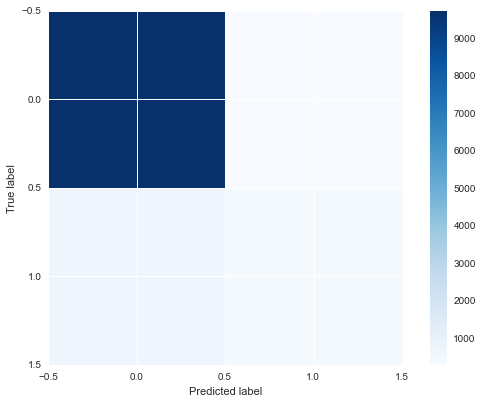

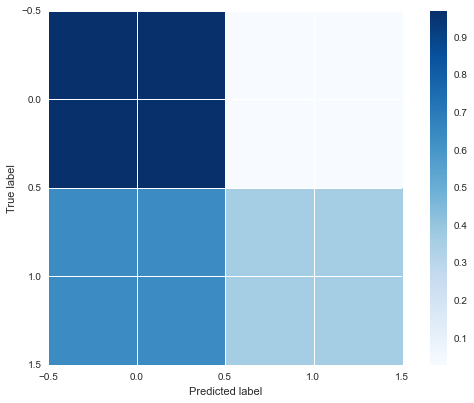

In [16]:
#plotting confusion matrix using http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#adding normalization by row
np.set_printoptions(precision=2)
def plot_confusion_matrix(cm, title='Title',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print('Confusion matrix without normalization')
print(conf)
plt.figure()
plot_confusion_matrix(conf,title='Confusion matrix without normalization')

cm_norm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_norm)
plt.figure()
plot_confusion_matrix(cm_norm, title='Normalized confusion matrix, by row')

plt.show()

Confusion matrix without normalization
[[9739  297]
 [ 727  411]]
Normalized confusion matrix
[[ 0.93  0.03]
 [ 1.03  0.58]]


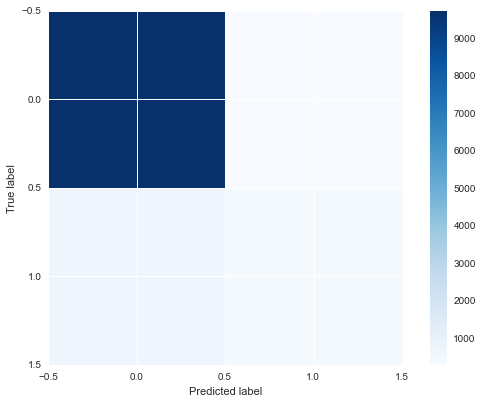

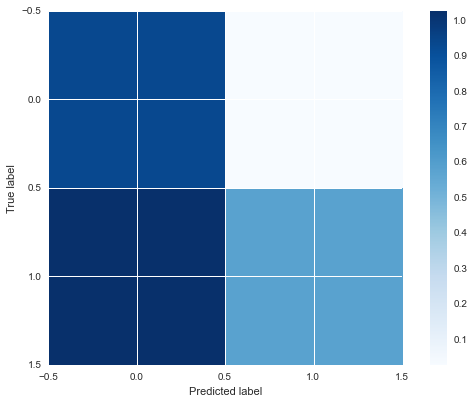

In [17]:
#plotting confusion matrix using http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#adding normalization by column
np.set_printoptions(precision=2)
def plot_confusion_matrix(cm, title='Title',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print('Confusion matrix without normalization')
print(conf)
plt.figure()
plot_confusion_matrix(conf,title='Confusion matrix without normalization')

cm_norm = conf.astype('float') / conf.sum(axis=0)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_norm)
plt.figure()
plot_confusion_matrix(cm_norm, title='Normalized confusion matrix, by column')

plt.show()

Our confusion matrices indicate this model does not produce many false positives but does produce many false negatives.  The recall is much better than the K-Nearest Neighbors model. The precision is slightly worse, but overall we feel this is a better model for classifying whether an arrest occured. 

In [18]:
pd.crosstab(y2, yhat2, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,97829,2535,100364
1,7004,4380,11384
All,104833,6915,111748


##Attribute Importance for Random Forest

One benefit of using a Random Forest is we can examine the model parameters and find out which attributes were important in classifying the data into the two categories.

In [19]:
df_reduced2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111748 entries, 0 to 117561
Data columns (total 40 columns):
Watch                             111748 non-null int64
PointX                            111748 non-null float64
PointY                            111748 non-null float64
Drug                              111748 non-null int64
ResponseTime                      111748 non-null float64
FC_ACCIDENTAL INJURY              111748 non-null float64
FC_AGGRAVATED ASSAULT             111748 non-null float64
FC_ANIMAL BITE                    111748 non-null float64
FC_ARSON                          111748 non-null float64
FC_ASSAULT                        111748 non-null float64
FC_AUTO THEFT - UUMV              111748 non-null float64
FC_BURGLARY                       111748 non-null float64
FC_CHILD (OFFENSES AGAINST)       111748 non-null float64
FC_CRIMINAL MISCHIEF/VANDALISM    111748 non-null float64
FC_DISORDERLY CONDUCT             111748 non-null float64
FC_DWI                 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=5, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


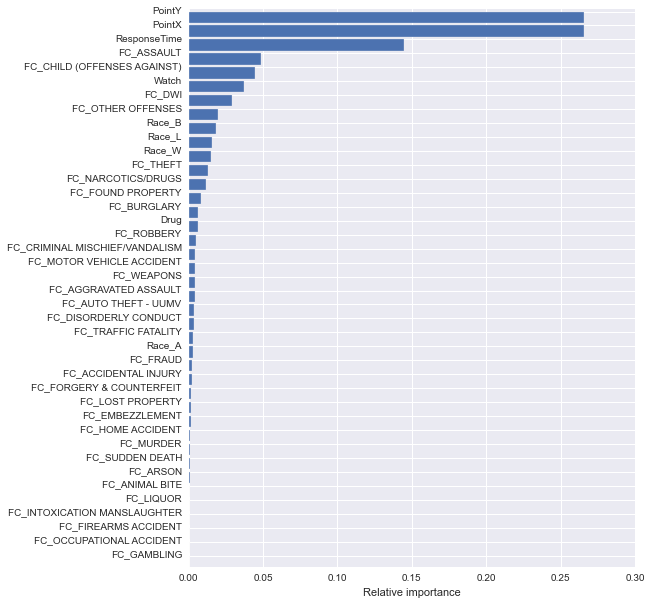

In [20]:
print(clf_RF)

plt.figure(figsize=(8,10))
# sort importances
indices = np.argsort(clf_RF.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(clf_RF.feature_importances_)),clf_RF.feature_importances_[indices])
plt.yticks(np.arange(len(df_reduced2.columns)) + 0.8, np.array(df_reduced2.columns)[indices])
_ = plt.xlabel('Relative importance')


Regarding the "oob_score," it tests the model fit score for test instances not in decision tree. When True, it saves these scores. We can then compare to the CV accuracy score to see if it's similar. If so, that's a good sign because new data are likely to see the same results. These are indeed similar.

The bigger the bar the better. The first two columns in our dataset are latitude and longitude (2 and 3 in the index. Response Time is also important (No. 5 in the index).

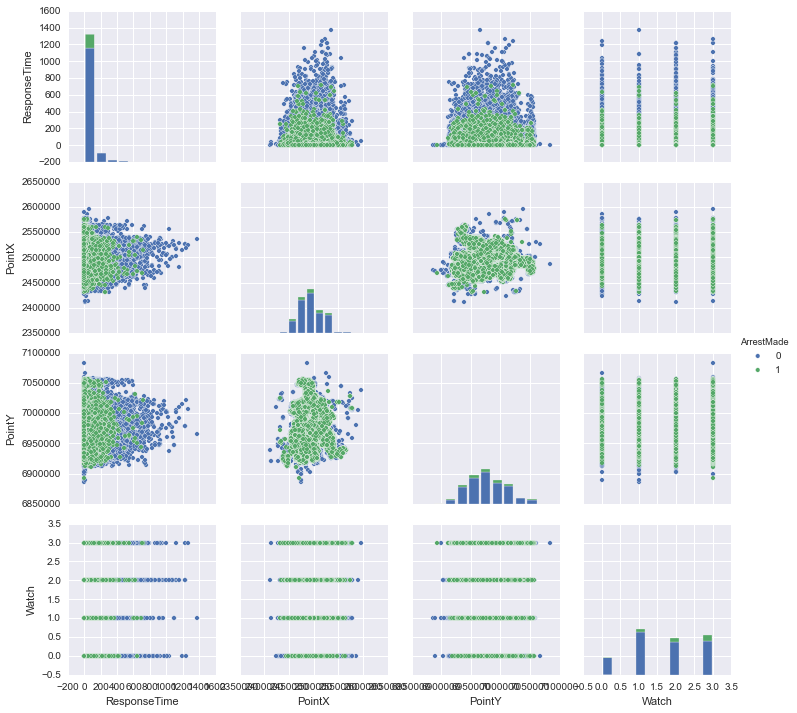

In [21]:
sns.pairplot(df_full, vars=['ResponseTime', 'PointX', 'PointY','Watch'], hue='ArrestMade')

The pairplot above shows how the the attributes with highest importance relate to response time. The blue dots - incidents with arrest made - are most closely clustered to the lower end of the response time. This supports what we've found many times in our exploration of this dataset: the quicker the response time the more likely an arrest will be made.

##Model 3 Logistic Regression

##*Contains Changes For Resubmission*
<a id='resubmit3'></a>

Our third model is our previous Logistics Regression classifier.  This model is a parametric linear model that in the previous assignment gave us the best results.  We will be comparing it to the previous two models on the basis of our new evaluation metric, the f-score. 

In [22]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

iter_num=0
for train_indices, test_indices in cv: 
    X_train = X2[train_indices]
    y_train = y2[train_indices]
    
    X_test = X2[test_indices]
    y_test = y2[test_indices]
    

# Normalilzing features to zero mean/1 standard deviation 
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=2,class_weight='auto') # get object
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

conf = mt.confusion_matrix(y_test,y_hat)
print(conf)
recall = mt.recall_score(y_test, y_hat)
precision = mt.precision_score(y_test, y_hat)
#print('KNN accuracy is ', total_accuracy)
print('Logistic Regression recall is ', recall)
print('Logistic Regression precision is ', precision)  

fscore = mt.f1_score(y_test,  y_hat)
print('Evaluation Metric: F-score is ', fscore)

[[8009 2027]
 [ 272  866]]
Logistic Regression recall is  0.760984182777
Logistic Regression precision is  0.299343242309
Evaluation Metric: F-score is  0.429670057058


## Finding the Best Method to Classify Arrest Made

##*Contains Changes For Resubmission*

In [23]:
#comparing KNN with Random Forest using already created clf variables
from sklearn.cross_validation import cross_val_score
fRF = cross_val_score(clf_RF, X2, y=y2, scoring = 'f1', cv=cv)


t = 2.26 / np.sqrt(10)

e = (1-f5)-(1-fRF)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(f5), np.mean(fRF))

Range of: 0.216937651799 0.259245614343
0.241701935848 0.47979356892


Analysis shows that the Random Forest model (mean f-score= .477) performs better than the 5-nearest neighbors (mean = .242), and we can reject the null hypothesis that there is no difference between the two. The best estimate of the difference is .236, which is a large increase. We will also compare this to the Logistic Regression model we built as part of the previous assignment. The Recall of the logistic regression model is very good. The precision, however, is much lower than our Random Forest model. The f-score, our evaluation metric, is comparable but lower by a few percentage points. 

In [24]:
#comparing Logistic Regresison with Random Forest using already created clf variables
from sklearn.cross_validation import cross_val_score
flogreg = cross_val_score(lr_clf, X2, y=y2, scoring = 'f1', cv=cv)

#Use t-score at the 95% Confidence Level
t = 2.26 / np.sqrt(10)

e = (1-fRF)-(1-flogreg)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(fRF), np.mean(flogreg))

Range of: -0.0357408456022 -0.0149244483701
0.47979356892 0.454460921933


Analysis shows that the Random Forest (mean f-score= .477) method is better than Logistic Regression (mean f-score= .454), and we can reject the null hypothesis that there is no difference between the two models. The best estimate for the difference is 0.023, which is not much.  Of the three classification models, the Random Forest performed better than both the 5-Nearest Neighbors model and the logistic regression model. 

##Deployment

Deploying this model could be done in several ways, but an interesting method that occured to us would be to use this model would be to run it on a new incident with a range of response times. If there is a response time threshold where the probability of arrest is greatly reduced, it would give dispatchers a target response time to try to meet.  

Another method of deployment could be for the Police Department to direct backup to incidents where a probability of arrest is likely, when backup is likely needed.  Deploying that backup more efficiently would decrease the turnaround time for those officers to get back out on the street. 

# Task 2 - Regression of Response Time

For the second task we will perform three types of regression on the variable Response Time. You may recall that Response Time is a variable we created from two existing dataset variables: call received and call dispatched. 

Building a regression model capable of predicting response time is interesting for several reasons.  First, in doing so we'll be able to examine what explanatory variables are associated with differences in response times and interpret what that could mean.  Second, an accurate prediction of response time would be useful by the police in setting expectations for callers who may be expecting an immediate response. We will evaluate these models using R-square. 

##Evaluation Metrics
For this task our evaluation metrics will be the R-square value of the model and the Mean Squared Error of the model. R-Square is a good measure for how well the model fits the data, but for non-parametric models may be misleading.  For this reason we'll also include the Mean Squared Error as a measure of how well the model performs predicting Response Time.

## Cross Validation Method

For the same reasons as Task 1, we chose again to use 10-fold cross validation as our cross validation method.  This time we will not be using a stratified cross-validation, however, since it is a continuous variable that we are attempting to predict.   


##Model 1: Multiple Linear Regression

In our previous examinations of this data set, it was noted that Response Time is extremely postively skewed with an extremely long tail, as shown in the histogram below.  In order to build a multiple linear regression model that behaves well we will need to transform the data so that the normality assumption is met.  A log transformation should be appropriate to achieve a more normal distribution, although we will first need to add a small value to each observation in order to solve the problem of ResponseTime observations with 0 values.  This is a reasonable step to take because it is 1) within the measurement error of the ResponseTime, which is in full minutes and 2) since it is impossible for an incident to have a response time that truly equals 0.  even if an officer is immediately dispatched, some fraction of a minute must have passed to communication with that officer.

One of the limitations of using Linear regression with this particular data set is the number of categorical variables that have been encoded as 1's or 0's.  With a binary explanatory variable there is not really a possibilty of a linear relationship between the explantory variable and the response, any model we build is likely to fit poorly to the data.

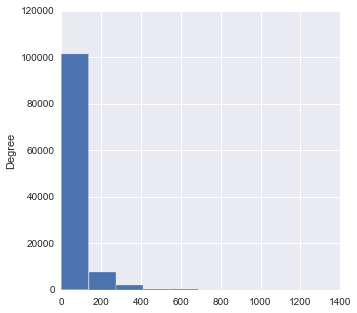

In [25]:
df_full['ResponseTime'].plot(kind='hist',figsize=(5,5))

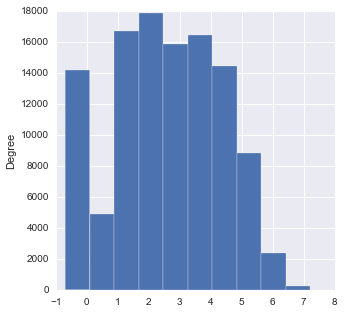

In [26]:
import math
df_reduced3 = df_final.copy()
df_reduced3 = df_final.drop(['DOW_Mon','DOW_Tue','DOW_Wed','DOW_Thu','DOW_Fri','DOW_Sat','DOW_Sun', 'Gang','Hate','Race_I'
                             ,'Race_U','Race_C','Race_N'],1) 

df_reduced3['LogResponseTime'] = np.log(df_reduced3['ResponseTime']+0.5)
df_reduced3 = df_reduced3.drop(['ResponseTime'],1)

df_reduced3['LogResponseTime'].plot(kind='hist',figsize=(5,5))

y = df_reduced3['LogResponseTime'].values
del df_reduced3['LogResponseTime']
X = df_reduced3.values


Our newly transformed LogResponseTime variable shows little evidence against normality. There are still a large number of very small Values, but given the rest of the distribution and the number of observations, the central limit theorem should cover us there. 

Mean Squared Error is:  2.89519642496
R Square is  0.147288583002


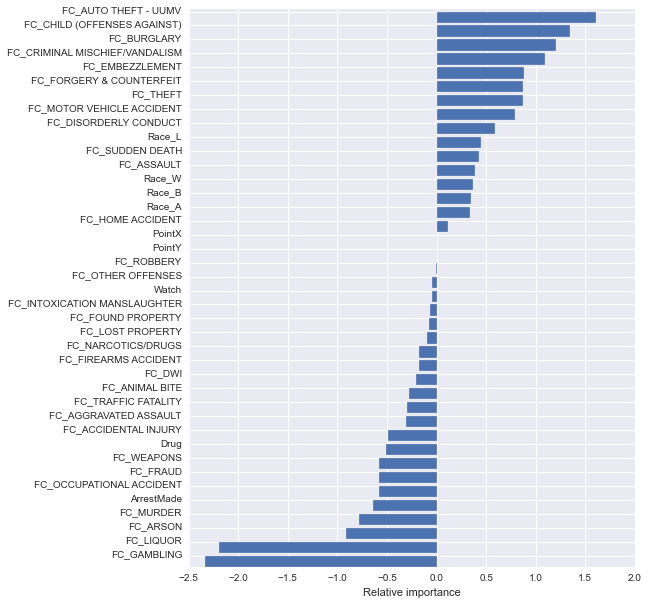

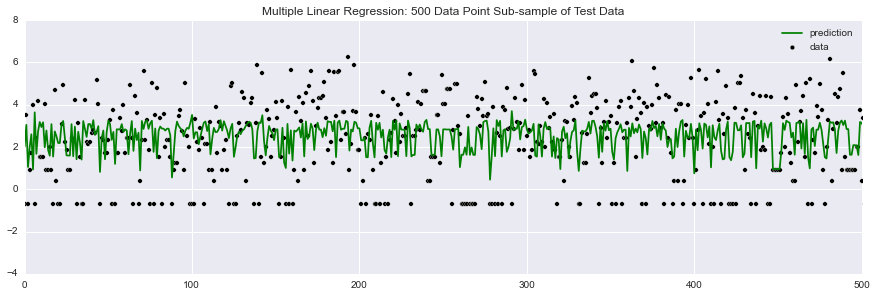

In [27]:
import numpy as np
from numpy.linalg import inv # inverse
from numpy import dot as mmult # a better name for matrix multiplication
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager
# create cross validation iterator
cv = KFold(len(y), n_folds=10)

# create variables we are more familiar with
yhat3 = np.zeros(len(y)) # we will fill this with predictions

# get a handle to the regression object, which defines the type
reg = LinearRegression(fit_intercept=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    reg.fit(X[train],y[train])
    yhat3[test] = reg.predict(X[test])
MSE_sklearn = mean_squared_error(y[test],yhat3[test])
R2_sklearn = reg.score(X[test],y[test])
print('Mean Squared Error is: ', MSE_sklearn)
print('R Square is ', R2_sklearn)

plt.figure(figsize=(8,10))
indices = np.argsort(reg.coef_)
# plot as bar chart
plt.barh(np.arange(len(reg.coef_)),reg.coef_[indices])
plt.yticks(np.arange(len(df_reduced3.columns)) + 0.8, np.array(df_reduced3.columns)[indices])
_ = plt.xlabel('Relative importance')

plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 1, 1)
ax1.set_xlim(0,500)
plt.scatter(np.linspace(0, len(y[test]), num=len(y[test])), y[test], c='k', label='data')
plt.plot(yhat3[test], c='g', label='prediction')
plt.legend()
plt.title("Multiple Linear Regression: 500 Data Point Sub-sample of Test Data")

With an R-square of .14, this model does not explain very much of the variance in Response Time, but was expected to the high number of binary variables in the data set.  Some of the regression coefficients are interesting however.  The "non-emergency" crimes of Auto Theft, Vandalism, Embezzlement, and Forgery have highly positive coefficients, meaning they are associated with longer response times.  Emergency crimes such as Arson, Aggravated Assault, and Murder have largely negative coefficients, which mean they are associated with lower response times.  These results are as you would expect.  Two coefficents that are unexpected are for crimes of Gambling and Liquor, which don't seem to be emergencies, but are associated with the biggest decrease in response time.  Gambling may be explained as chance by the low number of instances in the data set (only 5 observations), but there are 60 liquor offenses.  Another unexpected result is that Offenses against children appear to be associated with higher responses times. 

The second figure gives us a little bit of a window into where the model is making mistakes as it generalizes.  There is a range of response times between roughly 2 minutes and 35 minutes where the model does quite well.  Anything outside of that range it does quite poorly on. 

##*Contains Changes For Resubmission*

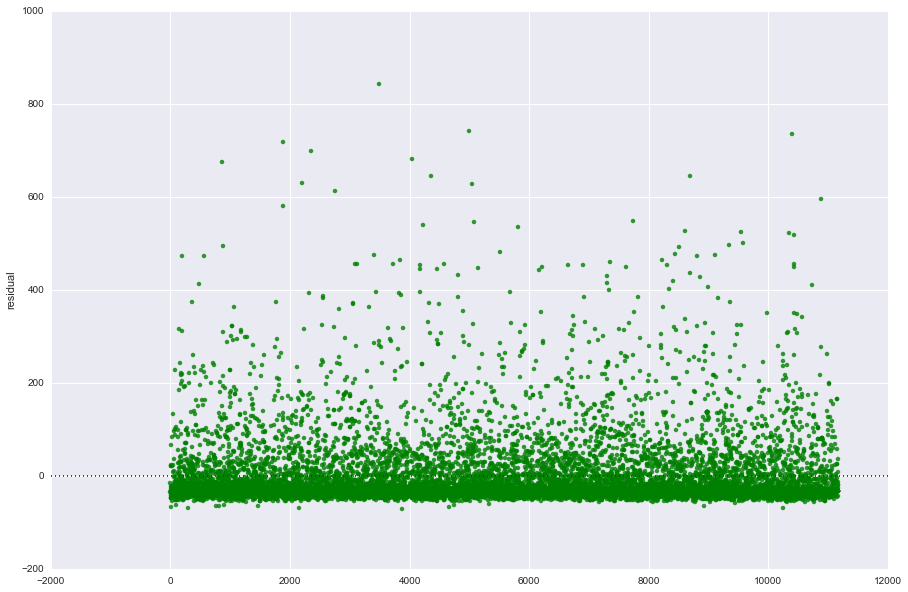

In [28]:
resid = pd.DataFrame(columns=['actual','predict','resid'])
resid['residual'] = np.exp(y[test])-np.exp(yhat3[test])
plt.figure(figsize=(15,10))
sns.residplot(np.linspace(0, len(y[test]), num=len(y[test])),resid['residual'], lowess=True, color="g")

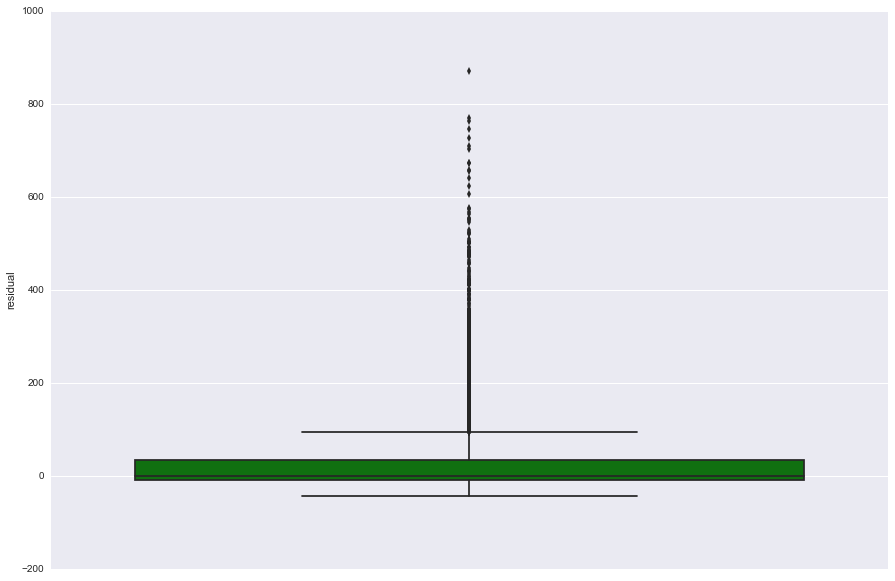

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(y=resid['residual'], color="g")

<a id='resubmit6'></a>
In the first plot above shows the residuals for each y-test and y-hat pair, and below that a boxplot of the residuals. While strongest around zero, you can see there is much variance in the residuals. The residuals are, however, more or less constant for the Response Time variable, and the median of the distribution is very close to zero

##Model 2: PCA Dimensionality Reduction

Another regression technique that we will apply in order to attempt to reduce the dimensionality of the data set is Principal Components Analysis.  This is a technique that can be very powerful for developing accurate regression models, but again may be very limited by the high number of binary variables in the data set.  

Mean Squared Error is:  2.963209142
R Square is  0.127257050833


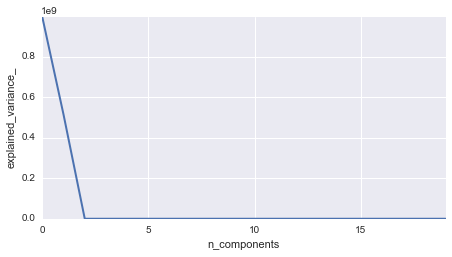

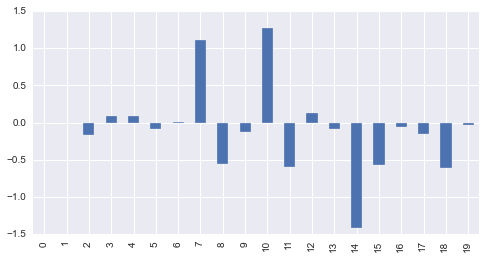

In [30]:
from sklearn.decomposition import RandomizedPCA
from sklearn.preprocessing import scale
n_components = 20

yhat4 = np.zeros(len(y))
pca = RandomizedPCA(n_components=n_components)

iterations = 150

reg2 = LinearRegression(fit_intercept=True)

X_reduced = pca.fit_transform(X)

plt.figure(1, figsize=(8, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

for train, test in cv:
    reg2.fit(X_reduced[train],y[train])
    yhat4[test] = reg2.predict(X_reduced[test])
    
MSE_sklearn = mean_squared_error(y[test],yhat4[test])
R2_sklearn = reg2.score(X_reduced[test],y[test])
print('Mean Squared Error is: ', MSE_sklearn)
print('R Square is ', R2_sklearn)

plt.figure(figsize=(8,4))
weights = pd.Series(reg2.coef_)
weights.plot(kind='bar')

The telling visualization that shows that this is poor model to use is the top graph above.  After the 2nd principle component, no other subsequent component is able to explain any more of the variance.  The PCA model has a smaller R-square than the multiple regression model as well. Again this indicates that even when decomposed into principle components there is not a strong linear relationship between Response Time and the explanatory variables.

##Model 3: KNN Regression

Because our attempts to regress this variable have been complicated by the presence of so many binary variables, we'll attempt to build a K-Nearest Neighbors regression. This model will take the average of the response times of the k nearest neighbors as a prediction for a new observation. The large number of binary variables should be more helpful in this type of model, but the fact we are averaging the responses times from a large number of points will hurt our ability to predict large response times. To prevent this as much as possible, we'll use a distance weighting in the model so that points closer to the prediction point carry more weight.

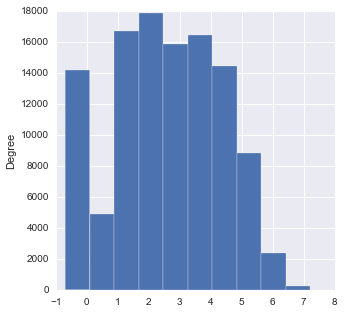

In [31]:
import math
df_reduced3 = df_final.copy()
df_reduced3 = df_final.drop(['DOW_Mon','DOW_Tue','DOW_Wed','DOW_Thu','DOW_Fri','DOW_Sat','DOW_Sun', 'Gang','Hate','Race_I'
                             ,'Race_U','Race_C','Race_N'],1) 

df_reduced3['LogResponseTime'] = np.log(df_reduced3['ResponseTime']+0.5)
df_reduced3 = df_reduced3.drop(['ResponseTime'],1)

df_reduced3['LogResponseTime'].plot(kind='hist',figsize=(5,5))

y = df_reduced3['LogResponseTime'].values
del df_reduced3['LogResponseTime']
X = df_reduced3.values


R Square is  -0.0405464616585
Mean Squared Error is  3.53294952518
Mean Absolute Error is  1.49963702675


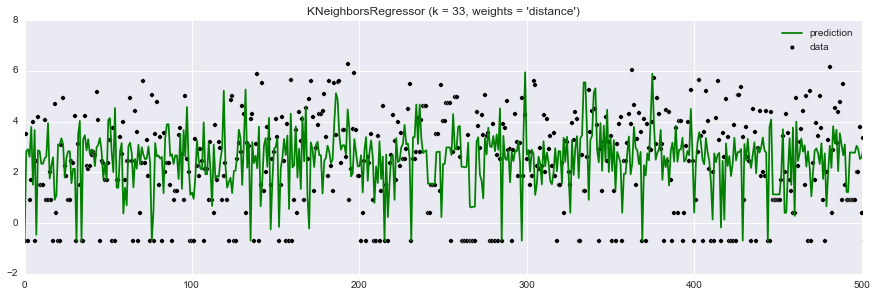

In [32]:
df_reduced4 = df_final.copy()
df_reduced4 = df_final.drop(['DOW_Mon','DOW_Tue','DOW_Wed','DOW_Thu','DOW_Fri','DOW_Sat','DOW_Sun', 'Gang','Hate','Race_I'
                             ,'Race_U','Race_C','Race_N'],1) 
df_reduced4['LogResponseTime'] = np.log(df_reduced4['ResponseTime']+0.5)
df_reduced4 = df_reduced4.drop(['ResponseTime'],1)

i =0
y_kn = df_reduced4['LogResponseTime'].values
del df_reduced4['LogResponseTime']
X_kn = df_reduced4.values

n_neighbors = 33
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
for train, test in cv:
    knn = KNeighborsRegressor(n_neighbors, weights='distance')
    y_knhat = knn.fit(X_kn[train], y_kn[train]).predict(X_kn[test])


R2_KNN= knn.score(X_kn[test],y_kn[test])
print('R Square is ', R2_KNN)
MSE_KNN = mean_squared_error(y_kn[test],y_knhat)
print('Mean Squared Error is ', MSE_KNN)
mae_KNN = mean_absolute_error(y_kn[test], y_knhat)
print('Mean Absolute Error is ', mae_KNN)

plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 1, 1)
ax1.set_xlim(0,500)
plt.scatter(np.linspace(0, len(y_kn[test]), num=len(y_kn[test])), y_kn[test], c='k', label='data')
plt.plot(y_knhat, c='g', label='prediction')
plt.legend()
plt.title("KNeighborsRegressor (k = 33, weights = 'distance')")

plt.show()


The R square for this model is very confusing. Because this is not modeling a linear relationship to the data, we wouldn't expect it to be good, but a negative value means a horizontal line would be a better model than the one we have chosen.  From examining a subset of data however, the model seems to do a better job than the multiple linear regression model of predicting outlier response times, and still performs well in the middle of the range. It's possible we haven't picked the best metric to evaluate these regression models.  We'll examine the residuals of the test set to confirm.  

##*Contains Changes For Resubmission*

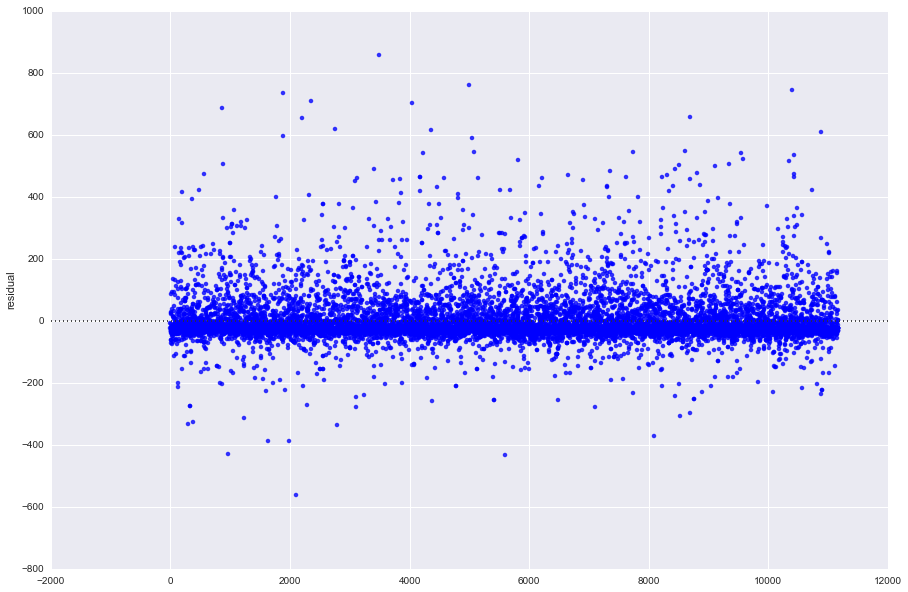

In [33]:
plt.figure(figsize=(15,10))
resid['residual'] = np.exp(y_kn[test])-np.exp(y_knhat)
sns.residplot(np.linspace(0, len(y_kn[test]), num=len(y_kn[test])),resid['residual'], lowess=True, color="b")

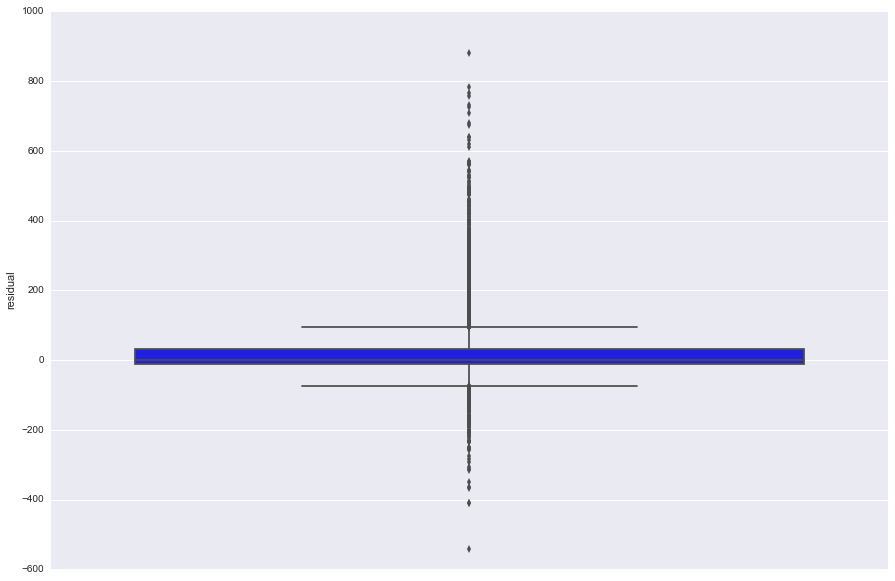

In [34]:
plt.figure(figsize=(15,10))
sns.boxplot(y=resid['residual'], color="b")

The  two residual plots above indicates constant variance with a denser distribution close to zero but still plenty of variance both positively and negatively.  The denser distribution of residuals backs up the conclusion we reached above, that the k-nearest neighbors regressor is performing a better job generalizing than our linear regression model. The R-Square and Mean Squared Error metrics do not show that, which is confusing.  

##*Contains Changes For Resubmission*

In [35]:
#comparing multiple linear and PCA using already created variables
from sklearn.cross_validation import cross_val_score
rsq1 = cross_val_score(reg, X, y=y, scoring = 'r2',cv=cv)
rsq2 = cross_val_score(reg2, X_reduced, y=y, scoring = 'r2',cv=cv)

t = 2.26 / np.sqrt(10)

e = (1-rsq1)-(1-rsq2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(rsq1), np.mean(rsq2))

Range of: -0.0139808341831 -0.0088146199727
0.128521642616 0.117123915538


<a id='resubmit7'></a>
The confidence interval above shows that there a significant difference between the multiple linear and PCA models. Analysis suggests a higher mean for the multiple linear regression model.

In [36]:
#comparing multiple linear and KNeighbors regression using already created variables
from sklearn.cross_validation import cross_val_score
acc1 = cross_val_score(knn, X_kn, y=y_kn, scoring = 'mean_squared_error',cv=cv)
acc2 = cross_val_score(reg, X, y=y,scoring = 'mean_squared_error', cv=cv)

#Use t-score at the 95% Confidence Level
t = 2.26 / np.sqrt(10)

e = (1-acc1)-(1-acc2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(acc1), np.mean(acc2))

Range of: 0.640111049545 0.72392443449
-3.60742967467 -2.92541193266


In [39]:
#comparing multiple linear and KNeighbors regression using already created variables
from sklearn.cross_validation import cross_val_score
rsq1 = cross_val_score(knn, X_kn, y=y_kn,scoring = 'r2', cv=cv)
rsq2 = cross_val_score(reg, X, y=y,scoring = 'r2', cv=cv)

#Use t-score at the 95% Confidence Level
t = 2.26 / np.sqrt(10)

e = (1-rsq1)-(1-rsq2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot)
print (np.mean(rsq1), np.mean(rsq2))

Range of: 0.184681731409 0.225209759473
-0.0764241028253 0.128521642616


Using confidence intervals to compare the multiple linear regression model (reg) and the k nearest regression model (KNN), we can reject the null hypothesis that the two models are not significantly different because the interval does not contain zero. Analysis suggest that the multiple linear regression has a lower mean squared error than the k nearest neighbor model, and a higher R-square. Both models could benefit from the addition of attributes that have a stronger relationship with the Response Time variable.  While it is obvious that response times vary according to the type of incident being reported, a variable that captures staffing levels or number of responses in a night, both continuous variables, would most likely be more appropriate for a regression model. 

##Deployment

As we consider deployment of this model, it's important to note that because the data are observational in nature, none of the factors associated with longer or shorter response times should be considered as having a casual link.  This is important because obviously the desire would be to shorten resopnse time by the police department, attacking the factors that have large coefficients in the model may or may not cause a corresponding decrease in response time.  Because of this, deployment of this model would be most useful as a measuring stick to observe any changes in department policy, technology, or operations going forward.   

# Exceptional Work: Gradient Boosted Regression Trees

This method is a stochastic approach to Regression based on binary decision trees. As with other decision tree based algorithms, no statistical assumptions exist with this data mining method.  This particular builds sequential models of simple binary trees where the subsequent trees are based on the residuals of the previous models.  We chose to try this type of algorithm because it has been shown to do well even when a large number of categorical variables are present. Our main goal in including this model was to explore the impact of varying the different paramaters of the Gradient Boosted Regression Tree on the performance of the model. 

Code based off of: http://nbviewer.ipython.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb

In [40]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

est = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                                loss='huber', random_state=0)
# create cross validation iterator
cv = KFold(len(y), n_folds=10)

# create variables we are more familiar with
yhat4 = np.zeros(len(y)) # we will fill this with predictions

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    est.fit(X[train],y[train])
    yhat4[test] = est.predict(X[test])
MSE_sklearn = mean_squared_error(y[test],yhat4[test])
mae = mean_absolute_error(y[test], yhat4[test])
R2_sklearn = est.score(X[test],y[test])
#total_accuracy = mt.accuracy_score(y, yhat4)
print('Mean Squared Error is: ', MSE_sklearn)
print('R Square is ', R2_sklearn)
print('Mean Absolute Error: %.4f' % mae)
#print ('Accuracy', total_accuracy)

Mean Squared Error is:  2.70203382018
R Square is  0.204180045362
Mean Absolute Error: 1.3423


#Exploring number of estimators and learning rate
To optimze the parameters for GBRT you must increase and decrease the number of estimators and the learning rate inversly. Here is a series of parameters and metrics to demonstrate that. The most common metric used to evalute GBRT is MAE. These operations were run on the untransformed data set, which is why the Error values and R-Square values are different than above. 

n_estimators=2000, max_depth=6, learning_rate=0.04

('Mean Squared Error is: ', 5622.4238059434638)
('R Square is ', 0.0039134317464964985)
Mean Absolute Error: 40.8264

n_estimators=1000, max_depth=6, learning_rate=0.04

('Mean Squared Error is: ', 5485.8841803728665)
('R Square is ', 0.028103228133147917)
Mean Absolute Error: 40.3142

n_estimators=500, max_depth=6, learning_rate=0.1

('Mean Squared Error is: ', 5517.5375989029344)
('R Square is ', 0.022495407355963337)
Mean Absolute Error: 40.4871

n_estimators=500, max_depth=6, learning_rate=0.04

('Mean Squared Error is: ', 5447.3348691551892)
('R Square is ', 0.034932747295108202)
Mean Absolute Error: 40.1491

**Best Performer**
n_estimators=100, max_depth=6, learning_rate=0.1

('Mean Squared Error is: ', 5398.1963993345253)
('R Square is ', 0.043638275633465229)
Mean Absolute Error: 40.1146

##Different Depth of Trees
n_estimators=1000, max_depth=9, learning_rate=0.04

('Mean Squared Error is: ', 5698.9606527306578)
('R Square is ', -0.009646080608407992)
Mean Absolute Error: 41.3444

n_estimators=100, max_depth=3, learning_rate=0.5

('Mean Squared Error is: ', 5409.1638333917053)
('R Square is ', 0.041695249968801695)
Mean Absolute Error: 40.2323
 
n_estimators=100, max_depth=6, learning_rate=0.5

('Mean Squared Error is: ', 5589.2341826953361)
('R Square is ', 0.009793411460566892)
Mean Absolute Error: 40.8782

n_estimators=100, max_depth=9, learning_rate=0.5

('Mean Squared Error is: ', 5904.7005081480111)
('R Square is ', -0.046095610848196689)
Mean Absolute Error: 42.5002

##*Contains Changes For Resubmission*
##Feature importance
Often features do not contribute equally to predict the target response. When interpreting a model, the first question usually is: what are those important features and how do they contributing in predicting the target response?

A GBRT model derives this information from the fitted regression trees which intrinsically perform feature selection by choosing appropriate split points. You can access this information via the instance attribute est.feature_importances_.

<a id='resubmit9'></a>
The plot below suggests that geography - our latitude and longitude Points X and Y - contribute to the most in predicting response time. After that, whether an arrest is made (ArrestMade)and the found property crime type (FC_FOUND PROPERTY) are the third and fourth highest contributors to response time.

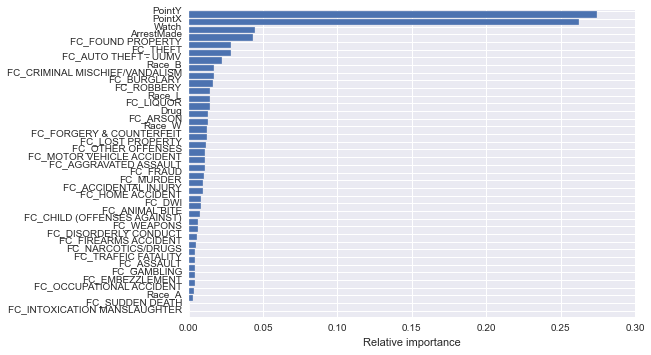

In [41]:
# sort importances
indices = np.argsort(est.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(df_reduced3.columns)), est.feature_importances_[indices])
plt.yticks(np.arange(len(df_reduced3.columns)) + 0.8, np.array(df_reduced3.columns)[indices])
_ = plt.xlabel('Relative importance')
 
#plt.figure(figsize=(15,10))
#weights = pd.Series(reg.coef_,index=df_reduced3.columns)
#weights.plot(kind='bar')

## Partial dependence
Partial dependence plots show the dependence between the response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected response as a function of the features we conditioned on.

The plot below contains 12 one-way partial depencence plots (PDP) each showing the effect of an idividual feature on the repsonse. They are the top 10 most important features, then the other race catagories for comparison. There is a strong drop in response time drops when an arrest is made or when there is a robbery. 
The bottom three plots show a two-way PDP. They allow you to see the interaction between two variable.

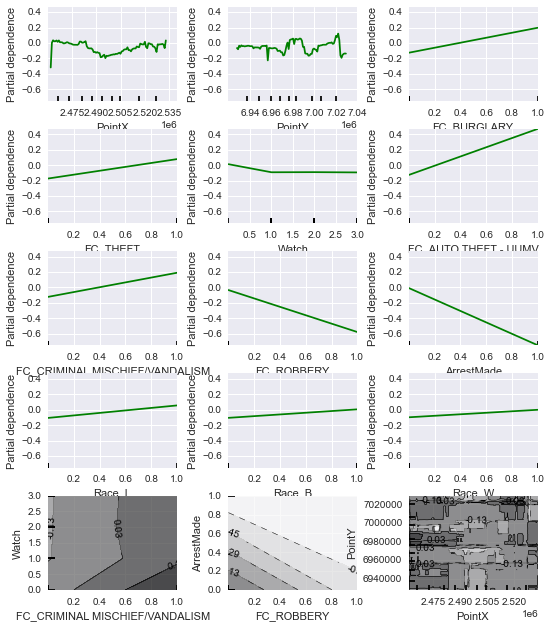

In [42]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['PointX', 'PointY','FC_BURGLARY', 'FC_THEFT','Watch',  'FC_AUTO THEFT - UUMV','FC_CRIMINAL MISCHIEF/VANDALISM','FC_ROBBERY', 'ArrestMade','Race_L','Race_B', 'Race_W',
            ('FC_CRIMINAL MISCHIEF/VANDALISM','Watch'), ('FC_ROBBERY', 'ArrestMade'),('PointX', 'PointY')]
fig, axs = plot_partial_dependence(est, X[train], features,
                                   feature_names=np.array(df_reduced3.columns), figsize=(8, 6))
plt.subplots_adjust(top=1.5)  # tight_layout causes overlap with suptitle

# Conclusion

We explored two tasks in this lab. First, we created three models to classify whether an arrest was made for a reported incident. See table below for a summary of the models. We have found that random forest is the best choice for classification of whether an arrest was made, based on the f-score evaluation metric.  Its non-parametric basis is also is a good fit for the characteristics of this data set, particularly the large number of categorical variables  
<a id='resubmit10'></a>

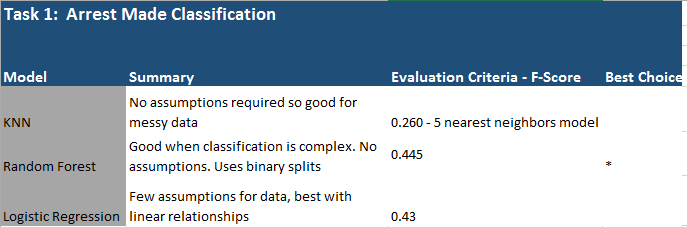

In [43]:
from IPython.display import Image
Image(filename='results1.png') 
#to be updated upon completion

The second task we created was regression on response time, which is a variable we created by subtracting the time the call was received from the time the call was dispatched. Our first task - in addition to our previous assignments - have suggested that response time is an important attribute for modeling whether an arrest was made. Consequently, understanding the attributes that explain variance in response time may ultimately help us understand the arrest made classification. The table below summarizes the results of our models for this task. As mentioned above, r-square may not have been the best choice of evaluation criteria.

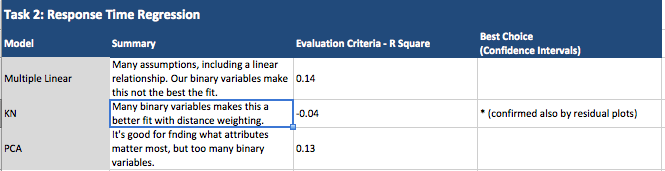

In [44]:
from IPython.display import Image
Image(filename='results2.png') 
#to be updated upon completion

Finally, we created a Gradient Boosted Regression Tree that reinforced some of our earlier conclusions about the relationships in the data.  It also performed significantly better at predicting the Log Response Time of incidents than our best regression model (MSE of 2.7 versue 2.89), and had a better R-Square (0.20 versus 0.14).  

Recently the Dallas Police Department has been under fire for its slow response time (http://crimeblog.dallasnews.com/2015/08/its-taking-dallas-police-longer-to-get-to-911-calls-now-but-chief-says-theres-a-good-reason.html/). An analysis similar to this one many help them identify patterns that may result in a review of policies and procedures to increase the number of arrests made, or improve response times.  Ideally more data would be added to these models, perhaps some that includes staffing levels, or aggregating the number of ongoing incidents to measure how many concurrent calls are occuring.